# cGAN

Vanilla cGAN： 使用MLP训练Vanilla cGAN

In [1]:
import os,sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [4]:
from torchvision import transforms
from torchvision.datasets import MNIST

In [5]:
import time

In [6]:
def now_time_str():
    return time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())

dataset

In [7]:
# Train or not
go_train = False
go_inference = True

In [8]:
root = "/home/shihui/Venus/"
means, stds = [0.5], [0.5]
batch_size = 64

In [9]:
dataset = MNIST(root, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
]))

dataloader = DataLoader(dataset, shuffle=True, num_workers=2, batch_size = batch_size)

model

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size = 100):
        super(Generator, self).__init__()
        def LinearBlock(num_in, num_out, bias = True):
            return [
                nn.Linear(num_in, num_out, bias = bias),
#                 nn.BatchNorm1d(num_out),
                nn.ReLU()
            ]
        self.G = nn.Sequential(
            *LinearBlock(input_size, 256),
            *LinearBlock(256, 512),
            nn.Linear(512, 28 * 28 * 1),
            nn.Tanh()
        )
        
    def forward(self, x, y):
        y = y.type(torch.FloatTensor)
        y = y.to(x.device)
        x = torch.cat([x,y], dim=1)
        return self.G(x).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def LinearBlock(num_in, num_out, bias = True):
            return [
                nn.Linear(num_in, num_out, bias = bias),
#                 nn.BatchNorm1d(num_out),
                nn.LeakyReLU(0.2)
            ]
        
        self.D = nn.Sequential(
            *LinearBlock(28 * 28 + 10, 512),
            *LinearBlock(512, 256),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image, label):
        x = torch.flatten(image, start_dim = 1)
        y = label.type(torch.FloatTensor)
        y = y.to(x.device)
        x = torch.cat([x, y], dim = 1)
        return self.D(x)
    
g = Generator()
d = Discriminator()

train

In [11]:
from torchvision.utils import make_grid, save_image

In [12]:
def show_retrived_batch_images(batches, means, stds, nrow = None, figsize = (15,15), title="images"):

    batch_size, num_channel = batches.size()[:2]
#     nrow = int(batch_size ** 0.5) 
    if nrow is None:
        nrow = 8

    images = make_grid(batches, nrow).detach().cpu().numpy().transpose((1,2,0))

    if num_channel == 3:
        for channel in range(num_channel):
            images[:,:,channel] = ( images[:,:,channel] * stds[channel] + means[channel] ) * 255.0
    else:
        images = (images * stds[0] + means[0]) * 255.0
    
    images = images.astype(int)
    
    figure = plt.figure(figsize=figsize)
    plt.imshow(images)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return plt

def save_retrived_batch_images(batches, means, stds, image_name, root = "images/"):

    plt = show_retrived_batch_images(batches, means, stds)
    plt.savefig("{}{}.png".format(root, image_name))
    plt.close()
    
def save_batch_images(batches, image_name, root = "images/"):
    save_image(batches, "{}{}".format(root, image_name), nrow=16)

In [13]:
class Trainer:
    
    def __init__(self, epoch, lr_D, lr_G, ):
        
        self.epochs = epoch
        self.lr_D = lr_D
        self.lr_G = lr_G
        self.criterion = nn.BCELoss()
        
    def onehot(self, x, num=10):
        return torch.tensor(np.eye(num)[x.cpu().detach().numpy().astype(int),:], dtype = torch.long)
        
    def train(self, G, D, dataloader, device = None):
        
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        optimizor_D = optim.Adam(D.parameters(), lr = self.lr_D, betas=(0.5,0.999))
        optimizor_G = optim.Adam(G.parameters(), lr = self.lr_G, betas=(0.5,0.999))
        
        one = torch.tensor([1], device = device, dtype = torch.float32)
        zero = torch.tensor([0], device = device, dtype = torch.float32)
        for epoch in range(self.epochs):
            
            print("Epoch:{}/{}".format(epoch+1, self.epochs))
            for i, (image, label) in enumerate(dataloader):
                image, label = image.to(device), label.to(device)
                y = self.onehot(label).to(device)
                
                bsize = image.size()[0]
                z = torch.randn((bsize, 90), device = label.device)
                ##### train the discriminator
                optimizor_D.zero_grad()
                
                out = D(image, y)
                
                fimage = G(z,y)
                fout = D(fimage, y)
                loss_D = self.criterion(fout, zero.expand([bsize, 1])) + self.criterion(out, one.expand([bsize, 1]))
                
                loss_D.backward()
                optimizor_D.step()
                
                ###### train the generator
                optimizor_G.zero_grad()
                
                fimage = G(z,y)
                out = D(fimage, y)
                loss_G = self.criterion(out, one.expand([bsize, 1]))
                
                loss_G.backward()
                optimizor_G.step()
                
                if i % 100 == 0:
                    print("[ loss_D: %2.6f ] [ loss_G: %2.6f] " %(loss_D, loss_G))
                    save_batch_images(fimage, "{}.png".format(epoch))
                    save_batch_images(image, "{}_true.png".format(epoch))
                
            print("[ loss_D: %2.6f ] [ loss_G: %2.6f] " %(loss_D, loss_G))
            save_batch_images(fimage, "{}.png".format(epoch))
            save_batch_images(image, "{}_true.png".format(epoch))

In [14]:
trainer = Trainer(50, 0.001, 0.001)
g.to("cuda")
d.to("cuda")

Discriminator(
  (D): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
if go_train:
    trainer.train(g, d, dataloader)
    # save
    torch.save(g.state_dict(), "models/{}_{}.pth".format("cGAN_MLPG_MNIST", now_time_str()))
    torch.save(d.state_dict(), "models/{}_{}.pth".format("cGAN_MLPD_MNIST", now_time_str()))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0', dtype=torch.int32)


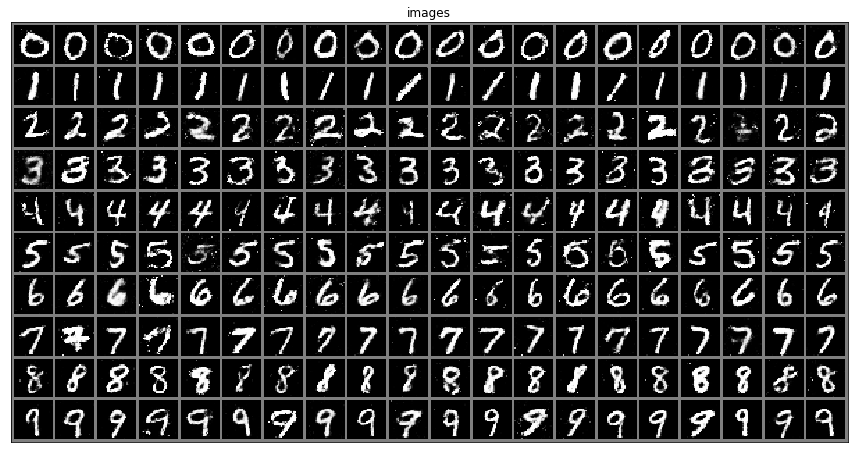

In [20]:
if go_inference:

    g.load_state_dict(torch.load("models/cGAN_MLPG_MNIST_2019_12_28_22_35_20.pth"))
    
    l = [[l for i in range(20)] for l in range(10)]
    l = torch.tensor(l, device = "cuda", dtype = torch.int).flatten()

    images = g(torch.randn( (l.size()[0], 90), device = "cuda"), trainer.onehot(l))
    print(l)
    show_retrived_batch_images(images, means, stds, nrow = 20).show()

该实验得到的结论有：

* 在GAN中，BN层会导致一个输入要依赖Batch内的信息，但是按理来说不应该依赖，BN层可能会导致一些问题。
